# Prediction Accuracy Visualization and Ensemble Analysis

**Purpose**: Visualize classifier predictions over time and analyze detector ensemble performance

**Key Features**:
- Time-series visualization of true/false predictions
- Ensemble aggregation analysis (combining multiple detectors)
- Minimal detector set identification for target accuracy
- Feature-specific analysis for single-variate detectors

**Use Cases**:
- Understanding when and where classifiers make mistakes
- Identifying complementary detector combinations
- Optimizing detector ensembles for accuracy

**Last Updated**: 2025-10-01

---

## 1. Setup and Configuration

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from itertools import combinations

# Shared configuration
from eval_config import (
    REAL_DATASETS,
    SINGLE_VARIATE_DETECTORS,
    BASE_PATH,
    setup_plot_style
)

# Setup plotting
setup_plot_style()
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.titlepad'] = 10
%matplotlib inline

In [2]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Select datasets to analyze
datasets = [
    "OutdoorObjects",  # Example: single dataset
    # "Electricity",
    # "NOAAWeather",
    # Add more datasets as needed
]

# Select detectors to analyze
# For feature testing mode, use single-variate detectors
detectors = SINGLE_VARIATE_DETECTORS  # ["CDBD", "IKS", "WindowKDE"]
# Or specify custom list:
# detectors = ["IKS"]

# Metrics used in experiments
metric1 = "ACCURACY"
metric2 = "RUNTIME"

# Paths
base_path = BASE_PATH
classifier = "HoeffdingTreeClassifier"

# Target accuracy for minimal set finding (e.g., 0.97 = 97% of max accuracy)
TARGET_ACCURACY_PERCENTAGE = 0.97

print(f"Analyzing {len(datasets)} dataset(s) with {len(detectors)} detector(s)")
print(f"Datasets: {datasets}")
print(f"Detectors: {detectors}")
print(f"Target accuracy: {TARGET_ACCURACY_PERCENTAGE*100:.0f}% of maximum")

Analyzing 1 dataset(s) with 3 detector(s)
Datasets: ['OutdoorObjects']
Detectors: ['CDBD', 'IKS', 'WindowKDE']
Target accuracy: 97% of maximum


## 2. Data Loading

Load prediction data from experiment logs. For each detector-dataset combination, we:
1. Find the experiment directory (including feature testing experiments)
2. Identify the best-performing configuration
3. Extract the true/false predictions from the log file

In [3]:
def find_best_configuration(exp_dir, base_path):
    """
    Find the configuration with highest accuracy in an experiment directory.
    
    Args:
        exp_dir: Experiment directory name
        base_path: Base path to experiments
        
    Returns:
        Path to log file of best configuration, or None if not found
    """
    job_info_path = os.path.join(base_path, exp_dir, "0", "job_infos.csv")
    
    if not os.path.exists(job_info_path):
        return None
    
    try:
        df = pd.read_csv(job_info_path)
        
        # Sort by accuracy (descending)
        df = df.sort_values(by=['ACCURACY'], ascending=False)
        
        # Find first valid SLURM job ID
        for idx in range(len(df)):
            job_id = df['OO_Info_SLURM_JOB_ID'].iloc[idx]
            if job_id != "OO_Info_SLURM_JOB_ID":  # Skip header rows
                log_path = os.path.join(
                    base_path, exp_dir, "0", "single_runs",
                    str(int(job_id)), f"{int(job_id)}_0_log.out"
                )
                if os.path.exists(log_path):
                    return log_path
        
        return None
    except Exception as e:
        print(f"Error processing {exp_dir}: {e}")
        return None


def extract_predictions(log_file):
    """
    Extract true/false predictions from a log file.
    
    Args:
        log_file: Path to log file
        
    Returns:
        List of 0s and 1s (0=incorrect, 1=correct prediction)
    """
    pattern = "General Info: True/False Predictions:"
    
    with open(log_file, 'r') as f:
        for line in f:
            if line.startswith(pattern):
                # Extract the list from the line
                items_string = line.split(": ")[2].strip()
                return eval(items_string)  # Convert string to list
    
    return None


# Load predictions for all detector-dataset combinations
print("\n=== Loading Prediction Data ===")
prediction_data = {}

# Get all experiment directories
all_dirs = sorted(os.listdir(base_path))

for dataset in datasets:
    for detector in detectors:
        # Look for matching experiment directories
        # Supports both regular and feature testing (ft) experiments
        for exp_dir in all_dirs:
            if detector in exp_dir and dataset in exp_dir:
                # Extract feature ID if this is a feature testing experiment
                if "_ft_" in exp_dir:
                    parts = exp_dir.split("_")
                    ft_idx = parts.index("ft")
                    if ft_idx + 1 < len(parts):
                        feature_id = parts[ft_idx + 1]
                        key = f"{detector}_ft{feature_id}"
                    else:
                        continue
                else:
                    key = detector
                
                # Find best configuration and extract predictions
                log_file = find_best_configuration(exp_dir, base_path)
                
                if log_file:
                    predictions = extract_predictions(log_file)
                    if predictions:
                        prediction_data[key] = predictions
                        accuracy = sum(predictions) / len(predictions)
                        print(f"  ✓ {key}: {len(predictions)} predictions, "
                              f"accuracy = {accuracy:.3f}")
                    else:
                        print(f"  ✗ {key}: Could not extract predictions")
                else:
                    print(f"  ✗ {key}: Log file not found")

print(f"\nLoaded predictions for {len(prediction_data)} configuration(s)")

if not prediction_data:
    print("\n⚠️  No prediction data found. Check:")
    print("   - Dataset and detector names are correct")
    print("   - Experiments have completed successfully")
    print("   - Log files contain prediction data")


=== Loading Prediction Data ===
  ✓ CDBD: 2000 predictions, accuracy = 0.084
  ✓ CDBD: 2000 predictions, accuracy = 0.084
  ✓ CDBD_ft0: 2000 predictions, accuracy = 0.035
  ✓ CDBD_ft10: 2000 predictions, accuracy = 0.037
  ✓ CDBD_ft11: 2000 predictions, accuracy = 0.035
  ✓ CDBD_ft12: 2000 predictions, accuracy = 0.056
  ✓ CDBD_ft13: 2000 predictions, accuracy = 0.054
  ✓ CDBD_ft14: 2000 predictions, accuracy = 0.058
  ✓ CDBD_ft15: 2000 predictions, accuracy = 0.035
  ✓ CDBD_ft16: 2000 predictions, accuracy = 0.035
  ✓ CDBD_ft17: 2000 predictions, accuracy = 0.049
  ✓ CDBD_ft18: 2000 predictions, accuracy = 0.035
  ✓ CDBD_ft19: 2000 predictions, accuracy = 0.035
  ✓ CDBD_ft1: 2000 predictions, accuracy = 0.035
  ✓ CDBD_ft20: 2000 predictions, accuracy = 0.035
  ✓ CDBD_ft2: 2000 predictions, accuracy = 0.035
  ✓ CDBD_ft3: 2000 predictions, accuracy = 0.035
  ✓ CDBD_ft4: 2000 predictions, accuracy = 0.035
  ✓ CDBD_ft5: 2000 predictions, accuracy = 0.060
  ✓ CDBD_ft6: 2000 predictions, a

## 3. Ensemble Aggregation

Compute the ensemble prediction by combining all detectors using OR logic:
- If **any** detector makes a correct prediction, the ensemble is correct
- This represents the best possible accuracy achievable by combining detectors

In [4]:
if prediction_data:
    # Compute ensemble aggregation (OR of all predictions)
    first_key = list(prediction_data.keys())[0]
    n_predictions = len(prediction_data[first_key])
    
    aggregation = [
        1 if any(preds[i] == 1 for preds in prediction_data.values()) else 0
        for i in range(n_predictions)
    ]
    
    prediction_data["Ensemble"] = aggregation
    
    # Calculate accuracies
    ensemble_accuracy = sum(aggregation) / len(aggregation)
    
    print(f"\n=== Ensemble Analysis ===")
    print(f"Individual detector accuracies:")
    for key, preds in prediction_data.items():
        if key != "Ensemble":
            acc = sum(preds) / len(preds)
            print(f"  {key:20s}: {acc:.3f}")
    
    print(f"\nEnsemble accuracy (OR): {ensemble_accuracy:.3f}")
    print(f"Improvement over best single detector: "
          f"{ensemble_accuracy - max(sum(p)/len(p) for k, p in prediction_data.items() if k != 'Ensemble'):.3f}")
else:
    print("No prediction data available for aggregation")


=== Ensemble Analysis ===
Individual detector accuracies:
  CDBD                : 0.084
  CDBD_ft0            : 0.035
  CDBD_ft10           : 0.037
  CDBD_ft11           : 0.035
  CDBD_ft12           : 0.056
  CDBD_ft13           : 0.054
  CDBD_ft14           : 0.058
  CDBD_ft15           : 0.035
  CDBD_ft16           : 0.035
  CDBD_ft17           : 0.049
  CDBD_ft18           : 0.035
  CDBD_ft19           : 0.035
  CDBD_ft1            : 0.035
  CDBD_ft20           : 0.035
  CDBD_ft2            : 0.035
  CDBD_ft3            : 0.035
  CDBD_ft4            : 0.035
  CDBD_ft5            : 0.060
  CDBD_ft6            : 0.035
  CDBD_ft7            : 0.035
  CDBD_ft8            : 0.055
  CDBD_ft9            : 0.084
  IKS                 : 0.085
  IKS_ft0             : 0.035
  IKS_ft10            : 0.099
  IKS_ft11            : 0.035
  IKS_ft12            : 0.056
  IKS_ft13            : 0.119
  IKS_ft14            : 0.058
  IKS_ft15            : 0.067
  IKS_ft16            : 0.035
  IKS_ft17 

## 4. Prediction Visualization

Visualize predictions over time as a heatmap:
- **Green** (✓): Correct prediction
- **Red** (✗): Incorrect prediction
- Each row represents a detector (or feature)
- Bottom row shows the ensemble aggregation

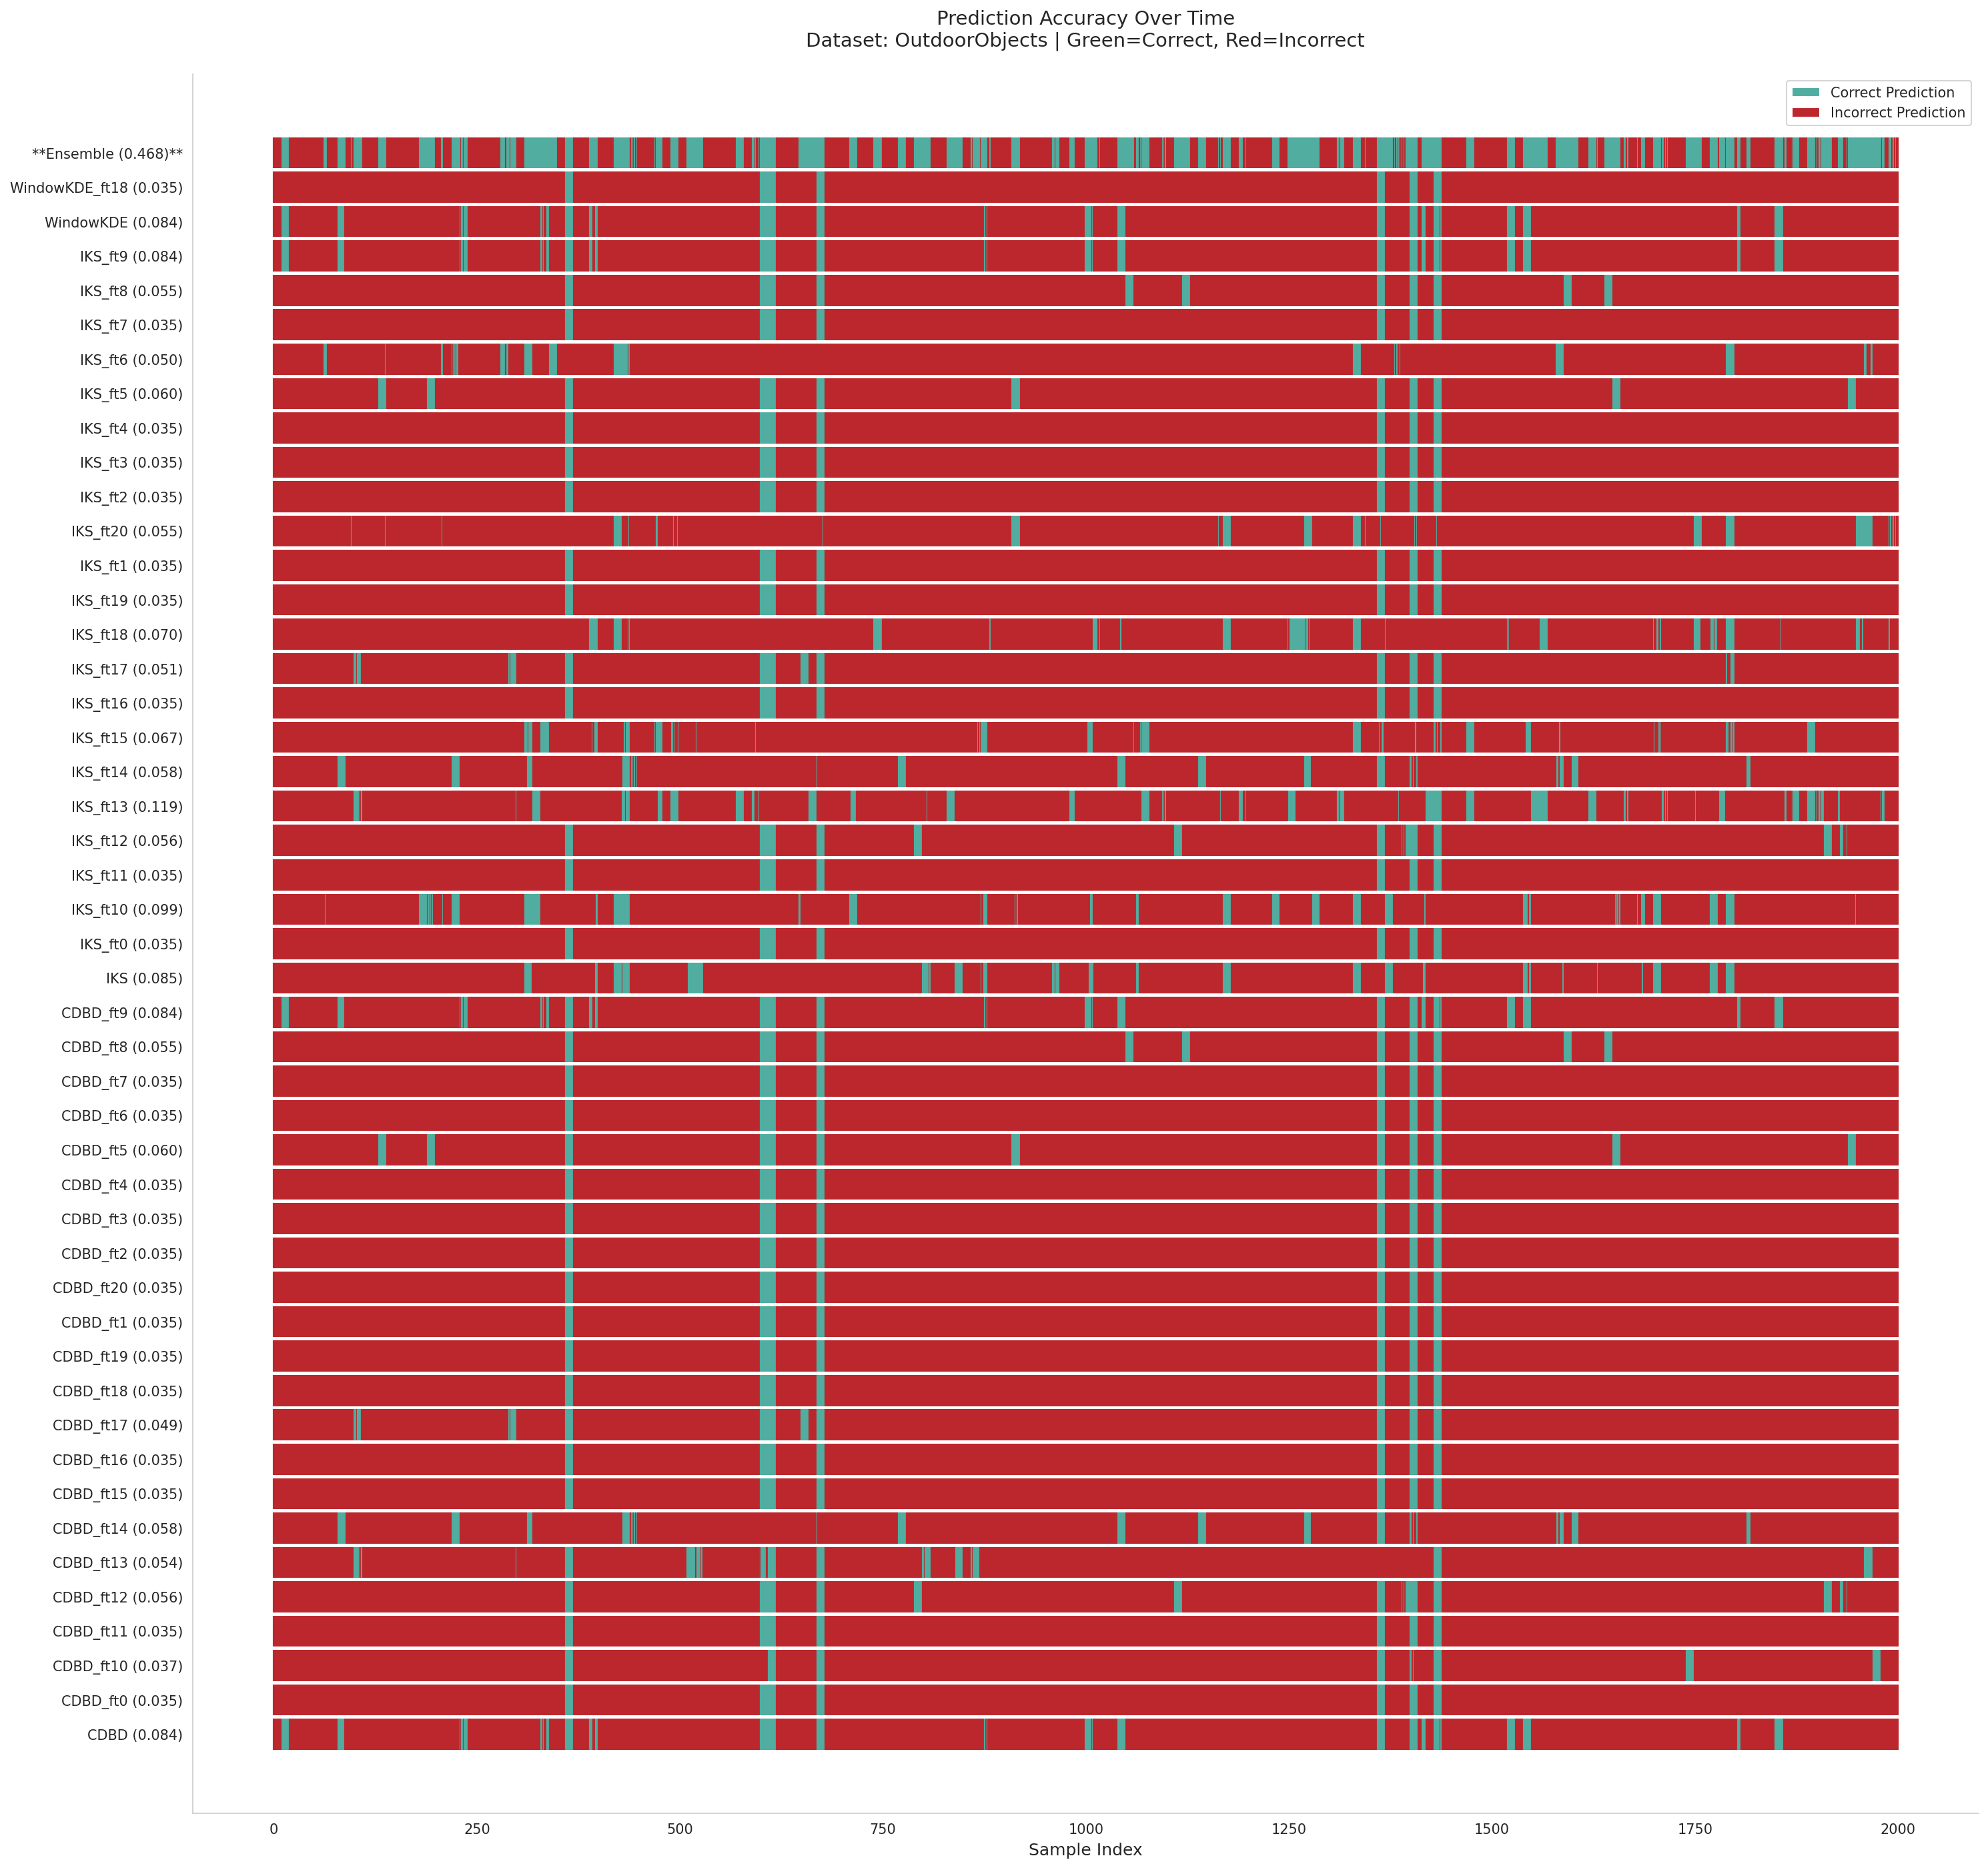


Visualization shows 2000 predictions across 47 configuration(s)


In [5]:
if prediction_data:
    # Create visualization
    n_detectors = len(prediction_data)
    fig_height = max(4, n_detectors * 0.4)
    
    fig, ax = plt.subplots(figsize=(20, fig_height), dpi=150)
    
    ylabels = []
    
    # Plot each detector's predictions
    for i, (key, predictions) in enumerate(prediction_data.items()):
        # Color: red for incorrect (0), green for correct (1)
        colors = ['#bc272d' if val == 0 else '#50ad9f' for val in predictions]
        
        # Plot as vertical lines
        ax.scatter(range(len(predictions)), [i] * len(predictions),
                  c=colors, s=500, marker='|', linewidths=2)
        
        # Add label with accuracy
        accuracy = sum(predictions) / len(predictions)
        label = f"{key} ({accuracy:.3f})"
        if key == "Ensemble":
            label = f"**{label}**"  # Emphasize ensemble
        ylabels.append(label)
    
    # Formatting
    ax.set_yticks(range(n_detectors))
    ax.set_yticklabels(ylabels, fontsize=10)
    ax.set_xlabel('Sample Index', fontsize=12)
    ax.set_title(f'Prediction Accuracy Over Time\n'
                f'Dataset: {datasets[0]} | Green=Correct, Red=Incorrect',
                fontsize=14, pad=20)
    ax.grid(False)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#50ad9f', label='Correct Prediction'),
        Patch(facecolor='#bc272d', label='Incorrect Prediction')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualization shows {len(predictions)} predictions across {n_detectors} configuration(s)")
else:
    print("No prediction data available for visualization")

## 5. Minimal Detector Set Analysis

Find the smallest combination of detectors that achieves the target accuracy.

**Goal**: Identify which detectors are complementary and can be combined to achieve high accuracy with minimal redundancy.

**Method**: Test all combinations starting from size 1, find the smallest sets that reach the target accuracy.

In [6]:
def covers_target(combination, target, target_percentage):
    """
    Check if a combination of detectors achieves the target accuracy.
    
    Args:
        combination: Tuple of detector keys
        target: Target prediction list (ensemble)
        target_percentage: Required percentage of target accuracy (e.g., 0.97)
        
    Returns:
        True if combination achieves target, False otherwise
    """
    # Combine predictions using OR logic
    combined = [0] * len(target)
    for key in combination:
        for i in range(len(target)):
            combined[i] = max(combined[i], prediction_data[key][i])
    
    # Calculate achieved accuracy
    combined_accuracy = sum(combined) / len(combined)
    target_accuracy = sum(target) / len(target)
    
    # Check if we meet the target percentage
    return combined_accuracy >= target_percentage * target_accuracy


def find_minimal_sets(detector_keys, target, target_percentage):
    """
    Find all minimal sets of detectors that achieve the target accuracy.
    
    Args:
        detector_keys: List of detector keys to consider
        target: Target prediction list (ensemble)
        target_percentage: Required percentage of target accuracy
        
    Returns:
        List of minimal detector combinations
    """
    n = len(detector_keys)
    minimal_sets = []
    
    # Try combinations of increasing size
    for size in range(1, n + 1):
        print(f"  Testing combinations of size {size}...")
        
        for combination in combinations(detector_keys, size):
            if covers_target(combination, target, target_percentage):
                minimal_sets.append(combination)
        
        # If we found any sets of this size, don't look for larger ones
        if minimal_sets:
            print(f"  Found {len(minimal_sets)} minimal set(s) of size {size}")
            return minimal_sets
    
    return None

In [ ]:
if prediction_data and "Ensemble" in prediction_data:
    print(f"\n=== Finding Minimal Detector Sets ===")
    print(f"Target: {TARGET_ACCURACY_PERCENTAGE*100:.0f}% of ensemble accuracy")
    
    # Get detector keys (exclude ensemble)
    detector_keys = [k for k in prediction_data.keys() if k != "Ensemble"]
    
    if len(detector_keys) > 1:
        # Find minimal sets
        minimal_sets = find_minimal_sets(
            detector_keys,
            prediction_data["Ensemble"],
            TARGET_ACCURACY_PERCENTAGE
        )
        
        if minimal_sets:
            print(f"\n{'='*60}")
            print(f"MINIMAL DETECTOR SETS")
            print(f"{'='*60}")
            
            ensemble_acc = sum(prediction_data["Ensemble"]) / len(prediction_data["Ensemble"])
            target_acc = TARGET_ACCURACY_PERCENTAGE * ensemble_acc
            
            for i, combo in enumerate(minimal_sets, 1):
                # Calculate accuracy of this combination
                combined = [0] * len(prediction_data["Ensemble"])
                for key in combo:
                    for j in range(len(combined)):
                        combined[j] = max(combined[j], prediction_data[key][j])
                
                combo_acc = sum(combined) / len(combined)
                
                print(f"\nSet {i}: {list(combo)}")
                print(f"  Accuracy: {combo_acc:.3f} (target: {target_acc:.3f})")
                print(f"  Size: {len(combo)} detector(s)")
                print(f"  Percentage of ensemble: {100*combo_acc/ensemble_acc:.1f}%")
            
            print(f"\n{'='*60}")
            print(f"Summary: Found {len(minimal_sets)} minimal set(s) of size {len(minimal_sets[0])}")
        else:
            print("\n⚠️  No combination achieves the target accuracy")
            print("   Try lowering TARGET_ACCURACY_PERCENTAGE")
    else:
        print("\n⚠️  Need at least 2 detectors for minimal set analysis")
else:
    print("No ensemble data available for minimal set analysis")


=== Finding Minimal Detector Sets ===
Target: 97% of ensemble accuracy
  Testing combinations of size 1...
  Testing combinations of size 2...
  Testing combinations of size 3...
  Testing combinations of size 4...
  Testing combinations of size 5...


## 6. Summary and Insights

In [ ]:
if prediction_data:
    print(f"\n{'='*60}")
    print(f"PREDICTION ANALYSIS SUMMARY")
    print(f"{'='*60}")
    
    print(f"\nDataset: {datasets[0]}")
    print(f"Detectors analyzed: {len([k for k in prediction_data.keys() if k != 'Ensemble'])}")
    print(f"Predictions per detector: {len(prediction_data[list(prediction_data.keys())[0]])}")
    
    if "Ensemble" in prediction_data:
        ensemble_acc = sum(prediction_data["Ensemble"]) / len(prediction_data["Ensemble"])
        best_single = max(
            sum(p)/len(p) for k, p in prediction_data.items() if k != "Ensemble"
        )
        
        print(f"\nAccuracy Results:")
        print(f"  Best single detector: {best_single:.3f}")
        print(f"  Ensemble (all detectors): {ensemble_acc:.3f}")
        print(f"  Improvement: +{ensemble_acc - best_single:.3f}")
        
        if 'minimal_sets' in locals() and minimal_sets:
            print(f"\nMinimal Set Results:")
            print(f"  Smallest effective size: {len(minimal_sets[0])} detector(s)")
            print(f"  Number of minimal sets: {len(minimal_sets)}")
    
    print(f"\n{'='*60}")
    
    print(f"\n💡 Key Insights:")
    print(f"   - Combining detectors can improve accuracy beyond any single detector")
    print(f"   - Minimal sets show which detectors are most complementary")
    print(f"   - Visualization reveals temporal patterns in prediction errors")
else:
    print("No data available for summary")

## 7. Export Results (Optional)

In [ ]:
# Export prediction data to CSV for further analysis
if prediction_data:
    # Create DataFrame
    df_export = pd.DataFrame(prediction_data)
    
    # Add sample index
    df_export.insert(0, 'Sample', range(len(df_export)))
    
    # Save to CSV
    output_file = f'predictions_{datasets[0]}.csv'
    df_export.to_csv(output_file, index=False)
    
    print(f"Predictions exported to: {output_file}")
    print(f"Shape: {df_export.shape}")
    print(f"\nFirst few rows:")
    print(df_export.head(10))
else:
    print("No data to export")